# Turbo Engine Failure Prediction

#### Load Data and Libraries

In [26]:
import numpy as np
import pandas as pd
import math
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

train_data = pd.read_csv("train_FD001.csv", sep=";")
test_data = pd.read_csv("test_FD001_100ex.csv", sep=";")

In [27]:
lenYes = len([1 for v in train_data["Failure_status"] if v=="yes"])
lenNo = len([1 for v in train_data["Failure_status"] if v=="no"])
print(lenYes, lenNo, lenYes/(lenYes+lenNo))

3100 17531 0.15025931850128446


## Preprocessing

### Encode class labels
Encoding is straightforward, as it is a binary classification problem.

In [28]:
label_mapping = {"yes": 1,
                 "no": 0}

train_data["Failure_status"] = train_data["Failure_status"].map(label_mapping)
test_data["Failure_status"] = test_data["Failure_status"].map(label_mapping)

### Separate labels and features

In [29]:
x = train_data.iloc[:, :-1]
y = train_data.iloc[:, -1]

x_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

### Normalization
Since the profile of many of the features seems to approach a standard distribution, the group opted for a z-score normalization, which is not only appropriate for this dataset, it also has the added benefit of centering the data, which is import for some of the classifiers that will be used such as SVM and neural networks.

In [30]:
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()

x = stdScaler.fit_transform(x)
x_test = stdScaler.transform(x_test)

### Dimension Reduction
The chosen approach for dimension reduction was a PCA. The basis for this decision is that not only is it benefitial for some classifiers, it is also useful for denoising, as we already know that the dataset has added noise and the contribution of noise to the total variance of the features is likely to be less significant than the patterns that will allow us to predict the label for each feature. Additionally, one of the main disadvantages of using a PCA for dimension reduction is that it becomes hard to understand what each resulting feature represents, however that is not a problem for our particular dataset, as the starting features are already anonymous, so there is little downside to this approach.

Since the features are anonymous, it is also not possible for us to know beforehand the ideal explained variance to be considered for this problem, so it is chosen based on the performance obtained by the classifiers, readjusting as needed for each classifier.

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, svd_solver='full') # set PCA to explain 90% of the variance
x = pca.fit_transform(x)
x_test = pca.transform(x_test)
print(sum(pca.explained_variance_ratio_), x.shape[1]) # it takes 9 components to explain at least 90% of the variance

0.9134299234365061 9


## Training

### Neural Network

Another model we experimented with was the Neural Network, the Multi-Layer Perceptron from sklearn. There were a lot of parameters to experiment with for the parameter grid, for the solver, activation and learning rate, we picked some of the ussually recomended choices and set them against eachother. The same went for the numerical values of alpha and learning rate init, however after the first trial of the later, it was clear that 0.001 was doing far better than other choices. The forced parameter max_iter, serves to make sure all of the combinations include 1000 iterations of maximum instead of the default 200, for them to have enough to converge. Finally the hidden layers were experimented with 2 and 3 layers, of sizes based on the number of features and 50% more and less, the best results happened when it had 12 sized layers, and having 3 layers didn't seem to give it a clear advantage over 2. 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

MLPClassifier().get_params()

parameter_grid = [
    {
        'solver': ['adam', 'sgd'],
        'max_iter': [1000],
        'hidden_layer_sizes': [(9,9), (12,12),(12,12,12)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
        'learning_rate_init': [0.001]
    }
]

grid_search = GridSearchCV(MLPClassifier(), parameter_grid, cv=5, scoring="accuracy", verbose=0)
grid_search.fit(x, y)
results = pd.DataFrame(grid_search.cv_results_)
y_pred = grid_search.predict(x_test)

print("\nCrossvalidation statistics:")
results = results[["rank_test_score", "params", "mean_test_score", "std_test_score"]].sort_values("rank_test_score")
results = results.drop('params', axis=1).join(pd.DataFrame(results.params.values.tolist()))
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 1000)
display(results.style.hide_index())

print("Classifier performance for best parameters:")
print(classification_report(y_test, y_pred))

## Ensemble

In an effort to try different options, we briefly looked at ensemble classifiers as a curiosity. Taking the best parameters for each of our classifiers, we make 3 classifiers and build a voting classifiers from it. Then train and test it considering 5-fold cross validation. Unfortunally, because we only have 3 classifiers all with relativy large accuracies as they stand, the ensemble model doesn't bring improvements, in fact the Neural Network and the Random forest likely vote against the SVM's correct prediction on the occassions that bring the accuracy down. Regardless we can see trough the confusion matrix that only 1 false positive and 7 false negatives appear.

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def get_confusion_matrix(clf, y_pred_test, y_test):
    cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
    return cm

def display_cm(clf, cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    


In [24]:
from sklearn.ensemble import VotingClassifier

nn_clf1 = MLPClassifier(activation='relu', alpha=0.05, hidden_layer_sizes=(12,12), learning_rate='adaptive', learning_rate_init=0.001, max_iter=1000, solver='adam')
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2', n_estimators=500, n_jobs=-1, random_state=0)
svm_clf = svm.SVC(gamma=100, C=10)

ensemble_clf = VotingClassifier(estimators=[('mlp1',nn_clf1), ('rf',rf_clf), ('svm',svm_clf)], voting='soft')

Fold: 1, Class dist.: [14024  2480], Acc: 0.962
Fold: 2, Class dist.: [14025  2480], Acc: 0.958
Fold: 3, Class dist.: [14025  2480], Acc: 0.962
Fold: 4, Class dist.: [14025  2480], Acc: 0.963
Fold: 5, Class dist.: [14025  2480], Acc: 0.960

CV accuracy: 0.961 +/- 0.002

 Generalization on the test set  
 

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        75
           1       0.95      0.72      0.82        25

    accuracy                           0.92       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100



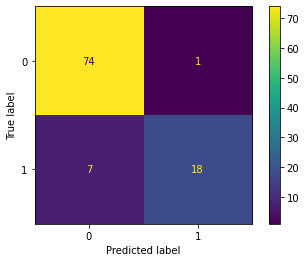

In [22]:
scores=[];    
kfold = StratifiedKFold(n_splits=5,  shuffle=True).split(x, y)

for k, (train, test) in enumerate(kfold):
    Xtrain=stdScaler.fit_transform(x[train])
    Xtest=stdScaler.transform(x[test])    
    ensemble_clf.fit(Xtrain, y[train])
    score = ensemble_clf.score(Xtest, y[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y[train]), score))
   
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

##Model trained with all training data
print('\n Generalization on the test set  \n \n')

Xtr=stdScaler.fit_transform(x)
Xtest=stdScaler.transform(x_test)    
ensemble_clf.fit(Xtr, y)
y_pred=ensemble_clf.predict(Xtest)
print(classification_report(y_test,y_pred))

cm = get_confusion_matrix(ensemble_clf, y_pred, y_test)
display_cm(ensemble_clf, cm)